In [1]:
# Try to actually make a data cube
import os
from astropy.modeling import models
from asdf import AsdfFile
from jwst import datamodels
from jwst.assign_wcs import miri
import matplotlib as mpl
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon
import numpy as np
import shapely.geometry as sg
import descartes as dc
import miricoord.mrs.mrs_pipetools as mpt
from miricoord.tel import tel_tools as tt
from astropy.io import fits
import pdb
import sys
import time

In [2]:
data_dir=os.path.expandvars('$MIRICUBE_DATA_DIR')
data_dir

'/ifs/jwst/wit/miri/gitdata/STScI-MIRI/miricube/'

In [3]:
file=data_dir+'driztest/det_image_seq1_MIRIFUSHORT_12SHORTexp1_photom.fits'

In [4]:
hdul=fits.open(file)# = datamodels.ImageModel(file)

In [5]:
hdr=hdul[1].header
raref,decref,v2ref,v3ref,rollref=hdr['RA_REF'],hdr['DEC_REF'],hdr['V2_REF'],hdr['V3_REF'],hdr['ROLL_REF']

In [6]:
thedata=hdul[1].data

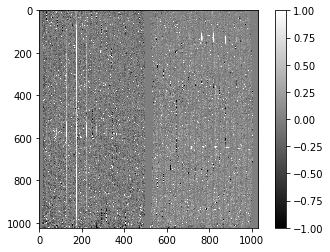

In [7]:
plt.figure()
plt.imshow(thedata, cmap='gray', vmin=-1,vmax=1)
plt.colorbar()

In [8]:
x,y=166,106

In [9]:
xytoablmodel=mpt.xytoablmodel('1A')
abtov2v3model=mpt.abtov2v3model('1A')

In [10]:
a0,b0,l0=xytoablmodel(x,y)
a1,b1,l1=xytoablmodel(x-0.5,y-0.5)
a2,b2,l2=xytoablmodel(x+0.5,y-0.5)
a3,b3,l3=xytoablmodel(x+0.5,y+0.5)
a4,b4,l4=xytoablmodel(x-0.5,y+0.5)
amin=(a1+a4)/2.
amax=(a2+a3)/2.
lmin=(a1+a2)/2.
lmax=(a3+a4)/2.
bmin=b0-0.17721/2.
bmax=b0+0.17721/2.

In [11]:
test=np.array([(a0,b0),(amin,bmin), (amax,bmin), (amax,bmax),(amin,bmax)])
test

array([[-0.35333569, -0.53163043],
       [-0.44719039, -0.62023543],
       [-0.25947835, -0.62023543],
       [-0.25947835, -0.44302543],
       [-0.44719039, -0.44302543]])

In [12]:
v2,v3=abtov2v3model(test[:,0],test[:,1])
#ra,dec=tt.jwst_v2v3toradec((-500,-501),(-300,-301),hdr=hdr)

In [13]:
from jwst.transforms.models import V23ToSky

In [14]:
angles = [-v2ref/3600., v3ref/3600., -rollref, -decref, raref]
axes = "zyxyz"
sky_rotation = V23ToSky(angles, axes_order=axes, name="v23tosky")
v2v3tosky=models.Scale(1/3600) & models.Scale(1/3600) | sky_rotation

In [15]:
ra,dec=v2v3tosky(v2,v3)
ra

array([36.99960729, 36.99958497, 36.99963655, 36.99962962, 36.99957802])

In [16]:
ra0=ra[0]
racorn=ra[1:]
de0=dec[0]
decorn=dec[1:]
xicorn=(racorn-ra0)*3600.*np.cos(de0*3.14159/180.)/0.1
etacorn=(decorn-de0)*3600./0.1

In [17]:
polygon = sg.Polygon([(xicorn[0],etacorn[0]),(xicorn[1],etacorn[1]),(xicorn[2],etacorn[2]),(xicorn[3],etacorn[3])])
list(polygon.exterior.coords)

[(-0.8004021886136967, 1.01305022780096),
 (1.049305631201335, 0.7429770822895421),
 (0.8007934438178375, -1.0137423293450354),
 (-1.0496446736356462, -0.7422926977724842),
 (-0.8004021886136967, 1.01305022780096)]

In [18]:
polygon2 = sg.Polygon([(0,0),(1,0),(1,1),(0,1)])

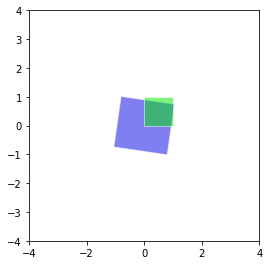

In [19]:
fig = plt.figure() 
ax = fig.add_axes((0.1,0.1,1.8,0.8))
patch = dc.PolygonPatch(polygon, facecolor=[0,0,0.9], edgecolor=[1,1,1], alpha=0.5) 
ax.add_patch(patch)
patch2 = dc.PolygonPatch(polygon2, facecolor=[0,0.9,0.0], edgecolor=[1,1,1], alpha=0.5) 
ax.add_patch(patch2)
plt.xlim([-4,4])
plt.ylim([-4,4])
ax.set_aspect(1)
plt.show()

In [20]:
polygon.area,polygon.intersection(polygon2).area

(3.316172170240387, 0.8121758236193984)

In [21]:
fracarea=polygon.intersection(polygon2).area/polygon.area
fracarea

0.2449136480029396

In [22]:
# pull out row 300
therow=300
xrow=np.arange(1032)
yrow=np.ones(1032)*therow
# centers
arow,brow,lrow=xytoablmodel(xrow,yrow)
v2row,v3row=abtov2v3model(arow,brow)
rarow,derow=v2v3tosky(v2row,v3row)

In [23]:
# Set up output image box
ramin,ramax=np.nanmin(rarow),np.nanmax(rarow)
demin,demax=np.nanmin(derow),np.nanmax(derow)
pixsz=0.2#arcsec
xi=(rarow-ramin)*3600./pixsz
eta=(derow-demin)*3600./pixsz
xsize=(np.ceil(np.nanmax(xi))).astype(int)
ysize=(np.ceil(np.nanmax(eta))).astype(int)
theimage=np.zeros((xsize,ysize))

In [24]:
xmin,xmax=0,1
ymin,ymax=0,1
grid = sg.Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])

In [25]:
from miricube.miricube import useful

2019-02-21 18:06:20,846 - stpipe - WARNING - /Users/dlaw/.conda/envs/conda-cdp7/lib/python3.6/site-packages/gwcs/selector.py:540: UserWarning: The input positions are not inside any region.
  warnings.warn("The input positions are not inside any region.")

2019-02-21 18:06:20,852 - stpipe - ERROR - IllegalArgumentException: Points of LinearRing do not form a closed linestring
2019-02-21 18:06:20,853 - stpipe - ERROR - Shell is not a LinearRing


ValueError: Null geometry has no type

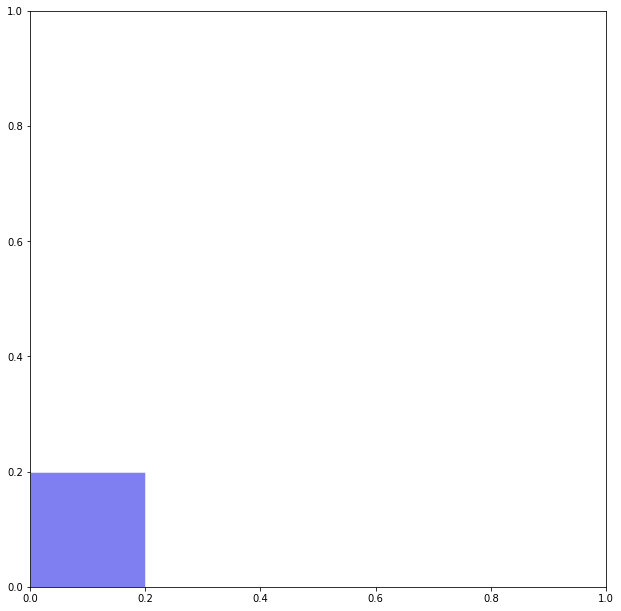

In [26]:
for i in range(xsize):
    for j in range(ysize):
        xmin,xmax=i*pixsz,(i+1)*pixsz
        ymin,ymax=j*pixsz,(j+1)*pixsz
        xmin,xmax,ymin,ymax
        grid = sg.Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])
        fig = plt.figure(figsize=(10,10)) 
        ax = fig.add_axes((0.1,0.1,0.8,0.8))
        patch = dc.PolygonPatch(grid, facecolor=[0,0,0.9], edgecolor=[1,1,1], alpha=0.5) 
        ax.add_patch(patch)
        for k in range(15,17):
            cc=useful.cornercoord2(xrow[k],yrow[k],xytoablmodel,abtov2v3model,v2v3tosky)
            cc2=useful.cornercoord_xieta(cc,ramin,demin,pixsz)
            poly=sg.Polygon([(cc2[0]),(cc2[1]),(cc2[2]),(cc2[3])])
            patch = dc.PolygonPatch(poly, facecolor=[0,0.9,0.], edgecolor=[1,1,1], alpha=0.5) 
            ax.add_patch(patch)
            plt.xlim([-1,xsize])
            plt.ylim([-1,ysize])
            ax.set_aspect(1)
            plt.show()
            time.sleep(5)
        
         

In [ ]:
list(grid.exterior.coords)

In [ ]:
xi

In [ ]:
xi[19]

In [ ]:
np.nanmax(xi)

In [ ]:
from miricube.miricube import useful

In [ ]:
cc=useful.cornercoord2(99,495,xytoablmodel,abtov2v3model,v2v3tosky)
cc

In [ ]:
ramin,demin

In [ ]:
cc2=useful.cornercoord_xieta(cc,ramin,demin,pixsz)
cc2

In [ ]:
poly=sg.Polygon([(cc2[0]),(cc2[1]),(cc2[2]),(cc2[3])])

In [ ]:
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_axes((0.1,0.1,0.8,0.8))
patch = dc.PolygonPatch(grid, facecolor=[0,0,0.9], edgecolor=[1,1,1], alpha=0.5) 
ax.add_patch(patch)
patch = dc.PolygonPatch(poly, facecolor=[0,0.9,0.], edgecolor=[1,1,1], alpha=0.5) 
ax.add_patch(patch)
plt.xlim([-1,xsize])
plt.ylim([-1,ysize])
ax.set_aspect(1)
plt.show()

In [ ]:
list(poly.exterior.coords)

In [ ]:
cc2

In [ ]:
cc

In [ ]:
poly.area,poly.intersection(grid).area